In [6]:
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [8]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

In [9]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f603671e7a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

We can test this on one of our flower photos. Let's start with a picturesque daisy.

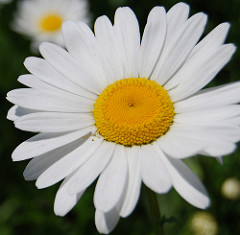

In [10]:
DATA_DIR = "data/cropped_flowers/"
img_path = DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img.show()

In [11]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

In [12]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


In [13]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens

tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [14]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


In [15]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3704, 0.2471, 0.1767], device='cuda:0', grad_fn=<SumBackward1>)

In [16]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3704, device='cuda:0', grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2471, device='cuda:0', grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1767, device='cuda:0', grad_fn=<SelectBackward0>)


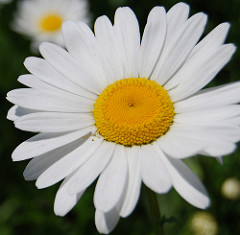

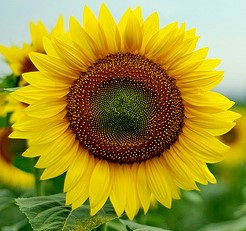

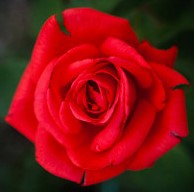

In [17]:
img_paths = [
    DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg",
    DATA_DIR + "sunflowers/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "roses/8032328803_30afac8b07_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    img.show()

In [20]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [21]:
clip_img_encodings = get_img_encodings(imgs)
clip_img_encodings

tensor([[-0.2722, -0.0156, -0.1793,  ...,  0.5815,  0.0871, -0.1442],
        [ 0.2590, -0.1023, -0.3442,  ..., -0.0083,  0.4956,  0.0825],
        [-0.0613,  0.4138,  0.0088,  ...,  0.3269,  0.4639, -0.1385]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

In [22]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A deep red rose flower"
]

In [23]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.5117,  0.1913,  0.1969,  ...,  0.0944, -0.0853, -0.2778],
        [ 0.0222,  0.3901,  0.3508,  ...,  0.1213,  0.0778, -0.1909],
        [-0.1101,  0.0108,  0.3330,  ...,  0.1293, -0.1022, -0.1859]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [24]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

In [25]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0730,  0.0273,  0.0281,  ...,  0.0135, -0.0122, -0.0396],
        [ 0.0031,  0.0547,  0.0492,  ...,  0.0170,  0.0109, -0.0268],
        [-0.0135,  0.0013,  0.0410,  ...,  0.0159, -0.0126, -0.0229],
        ...,
        [-0.0730,  0.0273,  0.0281,  ...,  0.0135, -0.0122, -0.0396],
        [ 0.0031,  0.0547,  0.0492,  ...,  0.0170,  0.0109, -0.0268],
        [-0.0135,  0.0013,  0.0410,  ...,  0.0159, -0.0126, -0.0229]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

In [26]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding

tensor([[-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0131],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0131],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0131],
        ...,
        [-0.0053,  0.0357,  0.0008,  ...,  0.0282,  0.0400, -0.0119],
        [-0.0053,  0.0357,  0.0008,  ...,  0.0282,  0.0400, -0.0119],
        [-0.0053,  0.0357,  0.0008,  ...,  0.0282,  0.0400, -0.0119]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexSelectBackward0>)

In [27]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.3705, 0.2472, 0.1943],
        [0.2648, 0.2994, 0.1810],
        [0.1700, 0.1753, 0.3078]], device='cuda:0', grad_fn=<ViewBackward0>)

In [29]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

['data/cropped_flowers/sunflowers/3062794421_295f8c2c4e.jpg',
 'data/cropped_flowers/sunflowers/5076821914_c21b58fd4c_m.jpg',
 'data/cropped_flowers/sunflowers/5994569021_749d5e2da3_n.jpg',
 'data/cropped_flowers/sunflowers/24459750_eb49f6e4cb_m.jpg',
 'data/cropped_flowers/sunflowers/4814106562_7c3564d2d9_n.jpg']

In [30]:
csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

In [31]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

In [32]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )
        
        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [33]:
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [34]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_flowers = torch.compile(model.to(device))

Num params:  44900355


In [35]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

In [36]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

In [37]:
epochs=100
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "05_images/"

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
    if epoch % 5 == 0 or epoch == int(epochs - 1):
        x_gen, x_gen_store = sample_flowers(text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(text_list))
        save_image(grid, save_dir + f"image_ep{epoch:02}.png")
        print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Step 008 | Loss: 0.5767589807510376
saved images in 05_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.2576102018356323
Epoch 2 | Step 008 | Loss: 0.2311933934688568
Epoch 3 | Step 008 | Loss: 0.18552955985069275
Epoch 4 | Step 008 | Loss: 0.18810884654521942
Epoch 5 | Step 008 | Loss: 0.17440348863601685
saved images in 05_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.13979792594909668
Epoch 7 | Step 008 | Loss: 0.1552017629146576
Epoch 8 | Step 008 | Loss: 0.15438774228096008
Epoch 9 | Step 008 | Loss: 0.12065087258815765
Epoch 10 | Step 008 | Loss: 0.11776888370513916
saved images in 05_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.1500750631093979
Epoch 12 | Step 008 | Loss: 0.16201552748680115
Epoch 13 | Step 008 | Loss: 0.10887126624584198
Epoch 14 | Step 008 | Loss: 0.14275376498699188
Epoch 15 | Step 008 | Loss: 0.13899880647659302
saved images in 05_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.1057809516787529
Epoch 17 | Step 008 | Loss: 0.1402

Now that the model is trained, let's play with it! What happens when we give it a prompt of something not in the dataset? Or can you craft the perfect prompt to generate an image you can imagine?

The art of crafting a prompt to get the results you desire is called **prompt engineering**, and as shown here, is dependent on the kind of data the model is trained on.

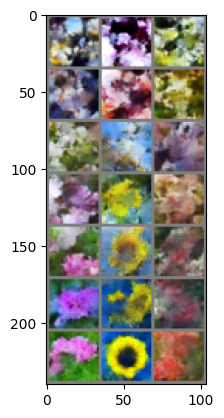

In [41]:

text_list = [
    "A pink daisy",
    "A sunflower",
    "A hibiscus"
]

model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


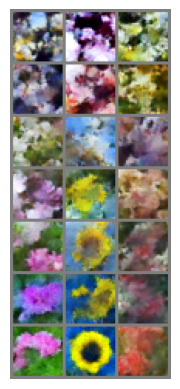

In [42]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
other_utils.save_animation(grids, "05_images/flowers.gif")

In [43]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}